# Cyclistic Case Study: Strategi Konversi Pengendara Berbasis Data


* **Author:** Samsur Hidayat
* **Role:** Data Analyst
* **Date:** Februari 2026
* **Tools:** SQL (DuckDB) untuk Pemrosesan Data, R (Tidyverse) untuk Analisis Statistik, Tableau untuk Visualisasi Geospasial.

---

## 1. Ringkasan Eksekutif (Executive Summary)

**Tujuan Bisnis:**
Mengidentifikasi perbedaan perilaku fundamental antara Pengendara Kasual (*Casual Riders*) dan Anggota Tahunan (*Annual Members*) untuk merancang strategi pemasaran yang efektif dalam mengonversi pengguna kasual menjadi anggota.

**Temuan Kunci:**
Analisis terhadap **5,7 juta perjalanan** sepanjang tahun 2025 mengungkap pola yang kontras:
1.  **Durasi:** Pengendara Kasual menghabiskan waktu rata-rata **2x lebih lama** bersepeda dibandingkan anggota, mengindikasikan penggunaan untuk rekreasi.
2.  **Waktu:** Aktivitas kasual melonjak drastis pada **akhir pekan (Sabtu-Minggu)**, sementara anggota mendominasi hari kerja.
3.  **Lokasi:** Peta panas menunjukkan konsentrasi Pengendara Kasual di area wisata dan pesisir pantai.

**Rekomendasi Strategis:**
Prioritaskan pemasangan iklan fisik (Billboards/QR Code) di stasiun-stasiun sepanjang **jalur pantai**. Pesan iklan harus bernuansa "Liburan Tanpa Batas" (*Unlimited Leisure Rides*) untuk memikat segmen rekreasi ini.

## 2. Metodologi: Mengapa SQL Diperlukan? (Data Processing)

Dataset ini berisi lebih dari **5,7 juta baris data**. Spreadsheet konvensional tidak mampu menangani volume ini secara efisien. Oleh karena itu, proses pembersihan data (*Data Cleaning*) dan manipulasi awal dilakukan menggunakan **SQL (DuckDB via DBeaver)** untuk memastikan integritas data.

**Proses Pembersihan di SQL (Backend):**
1.  **Filter Anomali:** Menghapus perjalanan < 1 menit (data error) dan > 24 jam (pencurian/lupa kembali).
2.  **Konversi Satuan:** Menghitung durasi perjalanan langsung ke satuan **Menit** (ride_length_minutes) untuk menghindari bias rata-rata detik.
3.  **Preservasi Lokasi:** Mempertahankan data Latitude/Longitude (start_lat, start_lng) untuk kebutuhan pemetaan di Tableau.

*> Catatan: Berikut adalah query SQL final yang digunakan untuk menghasilkan dataset bersih yang digunakan dalam notebook ini:*

```sql
/* DOKUMENTASI QUERY SQL (DuckDB) */
CREATE OR REPLACE TABLE all_trips_cleaned_v2 AS
SELECT 
    ride_id, 
    rideable_type, 
    started_at, 
    ended_at, 
    member_casual,
    -- Mempertahankan Data Lokasi untuk Tableau Map
    start_lat, start_lng, end_lat, end_lng, start_station_name,
    -- Menghitung durasi dalam MENIT (Desimal)
    date_diff('second', started_at, ended_at) / 60.0 AS ride_length_minutes,
    -- Mengambil hari (0=Minggu, ... 6=Sabtu)
    dayofweek(started_at) AS day_of_week
FROM 
    all_trips_combined
WHERE 
    date_diff('second', started_at, ended_at) > 60      -- Filter < 1 menit
    AND 
    date_diff('second', started_at, ended_at) < 86400;  -- Filter > 24 jam

## 3. Persiapan Lingkungan R (Environment Setup)

Setelah data mentah diproses dan dibersihkan menggunakan SQL, dataset final (`all_trips_cleaned_v2.csv`) kini siap untuk dianalisis.

Pada tahap ini, kita akan:
1.  Memuat pustaka **R (Tidyverse)** untuk manipulasi data tingkat lanjut dan visualisasi.
2.  Mengimpor dataset hasil pembersihan SQL.
3.  Melakukan verifikasi akhir (*sanity check*) untuk memastikan logika filter durasi SQL (> 1 menit) telah berhasil diterapkan.

In [ ]:
# 1. Memuat Library yang dibutuhkan
library(tidyverse)
library(lubridate) 
library(scales)     

# 2. Memuat Dataset
trips <- read_csv("/kaggle/input/all-trips-tableau-final/all_trips_tableau_final.csv", show_col_types = FALSE)

# 3. Verifikasi Kebersihan Data (Quality Check)
cat("Jumlah Baris Data:", nrow(trips), "\n")
cat("Durasi Terpendek (Menit):", min(trips$ride_length_minutes), "\n") 
cat("Durasi Terpanjang (Menit):", max(trips$ride_length_minutes), "\n")

# Melihat struktur data
glimpse(trips)

In [ ]:
# Tahap Finalisasi Data
trips_viz <- trips %>%
  mutate(
    # Mengubah angka hari (0-6) dari SQL menjadi Nama Hari (Minggu-Sabtu) agar mudah dibaca
    # week_start = 7 artinya Minggu adalah awal minggu
    day_name = wday(started_at, label = TRUE, abbr = FALSE, week_start = 7),
    
    # Memastikan urutan level member_casual agar konsisten di grafik (Casual dulu, baru Member)
    member_casual = factor(member_casual, levels = c("casual", "member"))
  )

# Cek apakah nama hari sudah terbentuk dengan benar
table(trips_viz$day_name)

## 4. Analisis & Visualisasi Statistik (Analyze)

### Insight 1: Perbedaan Gaya Berkendara (Durasi)
Apakah anggota tahunan menggunakan sepeda lebih lama karena mereka berlangganan? Data menunjukkan sebaliknya.

In [ ]:
# 1. Menghitung Rata-rata Durasi per Tipe User
duration_summary <- trips_viz %>%
  group_by(member_casual) %>%
  summarise(average_duration = mean(ride_length_minutes), .groups = 'drop')

# 2. Membuat Grafik Batang (Bar Chart)
ggplot(duration_summary, aes(x = member_casual, y = average_duration, fill = member_casual)) +
  geom_col(width = 0.6, color = "black", alpha = 0.8) +
  
  
  geom_text(aes(label = round(average_duration, 1)), vjust = -0.5, size = 5, fontface = "bold") +
  
  
  labs(
    title = "Pengendara Kasual Bersepeda 2x Lebih Lama",
    subtitle = "Rata-rata durasi perjalanan (Menit) sepanjang tahun 2025",
    x = NULL,
    y = "Durasi (Menit)"
  ) +
  scale_fill_manual(values = c("casual" = "#E69F00", "member" = "#56B4E9")) + # Warna Buta Warna Friendly
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(face = "bold", size = 16),
    axis.text = element_text(size = 12)
  )

### Insight 2: Preferensi Waktu (Pola Mingguan)
Kapan pengguna paling aktif? Grafik di bawah ini memetakan "denyut nadi" aktivitas mingguan Cyclistic.

In [ ]:
# Membuat Grafik Batang Ganda (Grouped Bar Chart)
trips_viz %>%
  group_by(member_casual, day_name) %>%
  summarise(number_of_rides = n(), .groups = 'drop') %>%
  
  ggplot(aes(x = day_name, y = number_of_rides, fill = member_casual)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7) +
  
  # Format Axis Y menjadi "K" (Ribuan) atau "M" (Jutaan) agar rapi
  scale_y_continuous(labels = label_number(scale_cut = cut_short_scale())) +
  
  # Styling
  labs(
    title = "Momen Akhir Pekan",
    subtitle = "Total perjalanan berdasarkan hari",
    x = "",
    y = "Jumlah Perjalanan"
  ) +
  scale_fill_manual(values = c("casual" = "#E69F00", "member" = "#56B4E9"), 
                    labels = c("Pengendara Kasual", "Anggota Tahunan")) +
  theme_minimal() +
  theme(
    legend.position = "top",
    legend.title = element_blank(),
    plot.title = element_text(face = "bold", size = 16),
    axis.text.x = element_text(angle = 45, hjust = 1) # Miringkan teks hari
  )

### Insight 3: Komposisi Pengguna (Market Share)
Sebelum masuk ke perilaku, mari kita lihat proporsi total pengguna. Siapa yang mendominasi jumlah perjalanan?

In [ ]:
# 1. Menghitung Total & Persentase
user_composition <- trips_viz %>%
  count(member_casual) %>%
  mutate(
    percentage = n / sum(n),
    label_text = scales::percent(percentage, accuracy = 1)
  )

# Menampilkan angka di konsol (agar tercatat)
print(user_composition)

# 2. Visualisasi Pie Chart (Donut Chart)
ggplot(user_composition, aes(x = 2, y = percentage, fill = member_casual)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0) +
  
  # Membuat lubang tengah (Donut Style)
  xlim(0.5, 2.5) +
  
  # Menambahkan Label Persentase di tengah
  geom_text(aes(label = label_text), position = position_stack(vjust = 0.5), color = "white", fontface = "bold", size = 6) +
  
  # Styling
  labs(
    title = "Dominasi Member vs Potensi Casual",
    subtitle = "Proporsi total perjalanan tahun 2025"
  ) +
  scale_fill_manual(values = c("casual" = "#E69F00", "member" = "#56B4E9")) +
  theme_void() + # Menghilangkan background kotak (bersih)
  theme(
    legend.position = "right",
    plot.title = element_text(face = "bold", size = 16, hjust = 0.5), # Judul di tengah
    plot.subtitle = element_text(hjust = 0.5)
  )

## 5. Visualisasi Interaktif & Geospasial (Tableau Dashboard)

Untuk analisis yang lebih mendalam mengenai **Lokasi (Geospatial)** dan **Waktu Sibuk (Heatmap)**, saya telah mengembangkan Dashboard Interaktif menggunakan Tableau.

Dashboard ini menjawab pertanyaan: *"Di mana lokasi favorit pengendara kasual dan kapan tepatnya kita harus menargetkan iklan?"*

> **Catatan:** Gambar di bawah adalah pratinjau statis. Silakan klik link untuk interaksi penuh.

**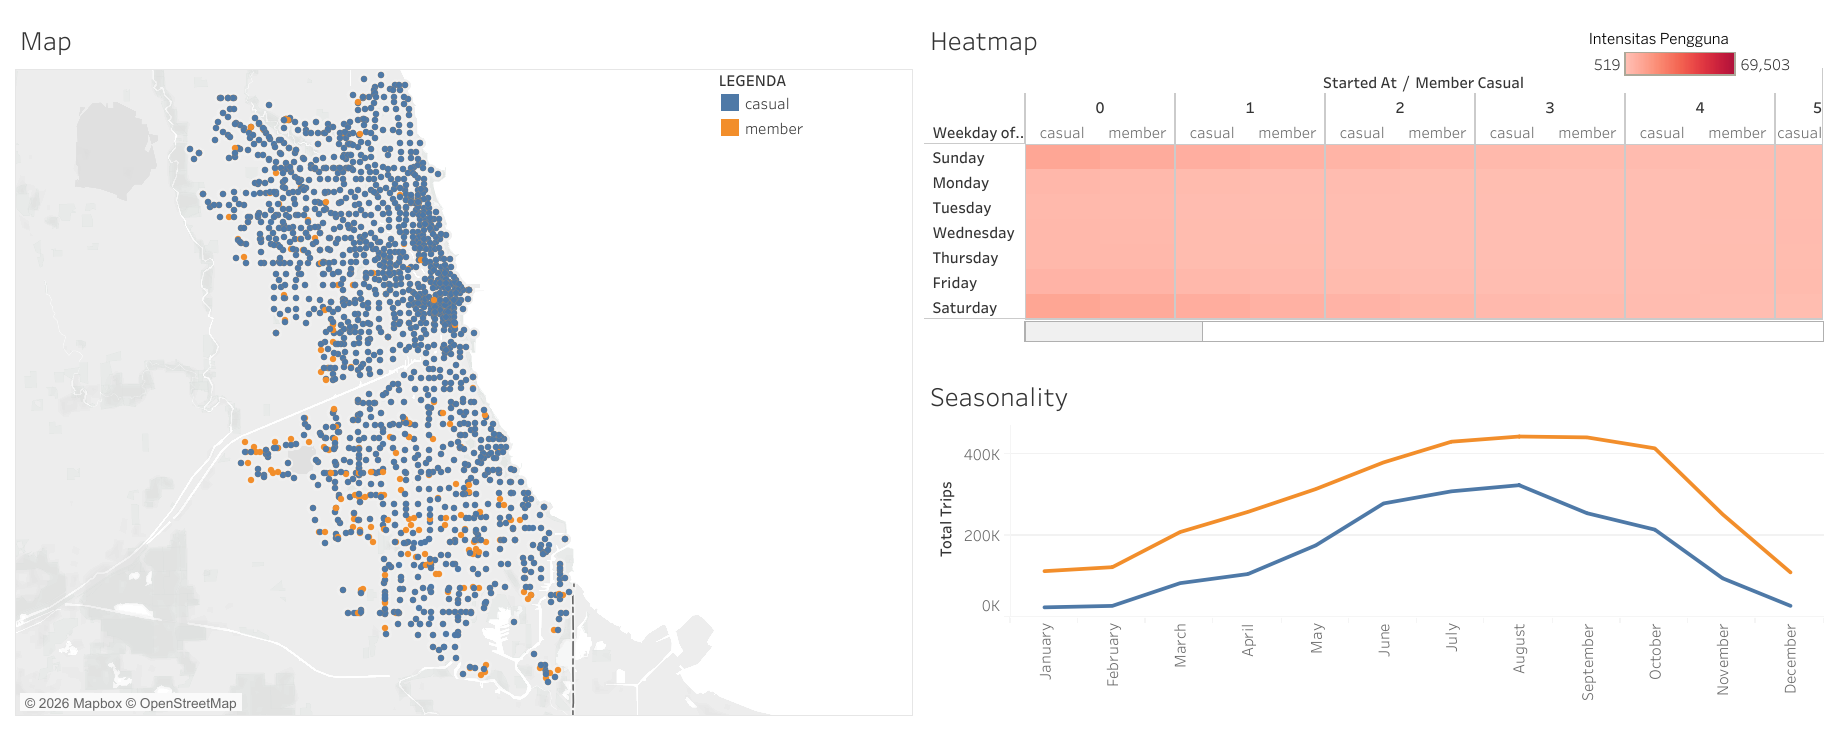**

#### 👉 [Klik di sini untuk Mencoba Dashboard Interaktif (Tableau Public)](https://public.tableau.com/views/All_trip_sepeda/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

**Temuan Visual dari Dashboard:**
1.  **Hotspot Lokasi (Map):** Pengguna Casual sangat terkonsentrasi di sepanjang **garis pantai** dan area rekreasi terbuka, sangat kontras dengan Member yang tersebar merata di **pusat kota** dan area perkantoran.
2.  **Peta Panas Waktu (Heatmap):** Aktivitas Casual memuncak pada pukul 10:00 - 16:00 di akhir pekan, sedangkan Member memiliki pola komuter (08:00 & 17:00).
3.  **Tren Musiman (Seasonality):** Jumlah perjalanan melonjak drastis pada musim panas (**Juni - Agustus**) dan menurun tajam di musim dingin, menandakan waktu terbaik untuk peluncuran kampanye adalah bulan Mei.

## 6. Rekomendasi Bisnis (Act)

Berdasarkan pola spasial dan temporal yang ditemukan dalam visualisasi (Tableau) dan analisis statistik (R), berikut adalah 3 strategi berbasis data untuk mengonversi Pengguna Casual menjadi Member:

#### 1. Strategi Lokasi: Dominasi Area Pesisir & Rekreasi
* **Bukti (Map):** Visualisasi peta menunjukkan konsentrasi tinggi pengguna Casual di sepanjang **garis pantai** dan area terbuka, berbeda dengan Member yang menyebar di area perkantoran.
* **Tindakan:** Prioritaskan pemasangan iklan fisik (Billboards/QR Code) di stasiun-stasiun docking sepanjang **jalur pantai**. Pesan iklan harus bernuansa "Liburan Tanpa Batas" (*Unlimited Leisure Rides*) untuk memikat segmen rekreasi ini.

#### 2. Produk Baru: "Summer Weekend Pass"
* **Bukti (Heatmap & Seasonality):** Data menunjukkan pengguna Casual memuncak drastis pada **Sabtu-Minggu** pukul 10:00-16:00, terutama selama bulan **Juni-Agustus**.
* **Tindakan:** Luncurkan keanggotaan musiman khusus (misal: *Summer Pass* atau *Weekend-Only Membership*). Ini memberikan opsi yang lebih murah daripada Full Membership bagi pengguna yang hanya aktif saat liburan, namun tetap mengikat mereka dalam ekosistem Cyclistic.

#### 3. Insentif Berbasis Durasi (Gamifikasi)
* **Bukti (Analisis R):** Rata-rata durasi berkendara Casual adalah **2x lebih lama** dibanding Member.
* **Tindakan:** Ubah durasi panjang tersebut menjadi peluang konversi. Buat tantangan di aplikasi (misal: *"Gowes 10 Jam Bulan Ini"*). Jika pengguna Casual mencapai target tersebut, berikan penawaran diskon khusus untuk upgrade ke Annual Member sebagai "hadiah" atas keaktifan mereka.